<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/Attention_Kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
from IPython.display import Image

# Create a directory to store images
os.makedirs("frames", exist_ok=True)

# Define the model
class XORAttentionModel(nn.Module):
    def __init__(self, d=4):  # d is the latent dimension
        super(XORAttentionModel, self).__init__()

        self.d = d  # Latent dimension

        # Kernel transformation (produces a 2x2 matrix)
        self.kernel_layer = nn.Linear(2, 4)  # Maps 2 tokens to 4 values (reshaped as 2x2)

        # Value transformation (produces a 2xd matrix)
        self.value_layer = nn.Linear(2, 2 * d)  # Maps 2 tokens to 2*d values

        # New projection layer: projects 2d down to 2D for visualization
        self.projection_layer = nn.Linear(2 * d, 2)  # Maps [batch_size, 2d] → [batch_size, 2]

        # Final output layer (maps projected 2D representation to scalar output)
        self.output_layer = nn.Linear(2, 1)

    def forward(self, x):
        batch_size = x.shape[0]

        # Learnable kernel K(X', X; W_K) -> reshaped to 2x2
        K = self.kernel_layer(x)  # Shape: [batch_size, 4]
        K = K.view(batch_size, 2, 2)  # Reshape to [batch_size, 2, 2]

        # Softmax over the last dimension (row-wise normalization)
        A = torch.softmax(K, dim=-1)  # Shape: [batch_size, 2, 2]

        # Learnable value transformation V(X; W_V) -> reshaped to 2xd
        V = self.value_layer(x)  # Shape: [batch_size, 2*d]
        V = V.view(batch_size, 2, self.d)  # Reshape to [batch_size, 2, d]

        # Apply attention: O = A * V
        O = torch.bmm(A, V)  # Shape: [batch_size, 2, d]

        # Flatten the output to shape [batch_size, 2*d]
        O = O.view(batch_size, 2 * self.d)

        # Pass through the new projection layer to get a 2D representation
        O_projected = self.projection_layer(O)  # Shape: [batch_size, 2]

        # Pass through the final output layer
        out = self.output_layer(O_projected)  # Shape: [batch_size, 1]

        return torch.sigmoid(out), A, O_projected  # Return attention matrix and 2D transformed representations
# Instantiate the model
model = XORAttentionModel(d=4)
# Training Data for XOR
X_train = torch.tensor([[0,0], [0,1], [1,0], [1,1]], dtype=torch.float32)
y_train = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)  # XOR labels


# Define loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss for XOR classification
optimizer = optim.Adam(model.parameters(), lr=0.01)


Epoch [0/50], Loss: 0.7039
Epoch [10/50], Loss: 0.6786
Epoch [20/50], Loss: 0.6501
Epoch [30/50], Loss: 0.5751
Epoch [40/50], Loss: 0.4217


<ipython-input-8-bb819e7154bc>:101: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


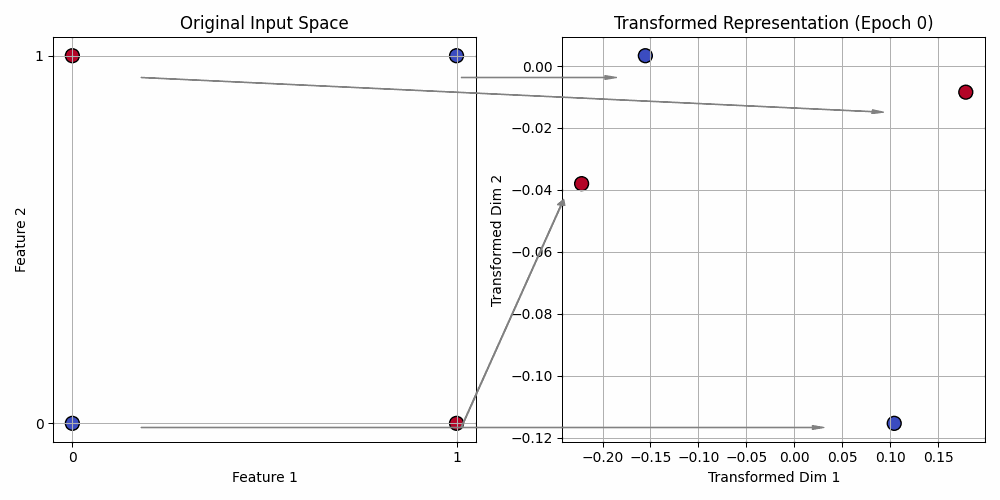

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import imageio
import os
from IPython.display import Image

# Create a directory to store images
os.makedirs("frames", exist_ok=True)

# Function to visualize transformation with **perfect arrows**
def plot_transformed_representations_with_arrows(model, X_train, y_train, epoch):
    """
    Plots both the original and transformed representation of inputs,
    with **perfectly aligned** arrows between left and right plot.
    """
    with torch.no_grad():
        _, _, transformed_points = model(X_train)  # Get 2D representations

    # Convert to NumPy
    transformed_points = transformed_points.numpy()
    y_train = y_train.numpy().flatten()
    original_points = X_train.numpy()  # Keep the original input points

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Left plot: Original input space
    ax[0].scatter(original_points[:, 0], original_points[:, 1], c=y_train, cmap="coolwarm", s=100, edgecolors='k', label="Original Points")
    ax[0].set_title("Original Input Space")
    ax[0].set_xlabel("Feature 1")
    ax[0].set_ylabel("Feature 2")
    ax[0].set_xticks([0, 1])
    ax[0].set_yticks([0, 1])
    ax[0].grid(True)

    # Right plot: Transformed space
    ax[1].scatter(transformed_points[:, 0], transformed_points[:, 1], c=y_train, cmap="coolwarm", s=100, edgecolors='k', label="Transformed Points")
    ax[1].set_title(f"Transformed Representation (Epoch {epoch})")
    ax[1].set_xlabel("Transformed Dim 1")
    ax[1].set_ylabel("Transformed Dim 2")
    ax[1].grid(True)

    # **Final fix**: No gaps between arrows and points
    fig.canvas.draw()

    for i in range(len(original_points)):
        # Get original and transformed points in **display coordinates**
        orig_disp_coords = ax[0].transData.transform(original_points[i])
        trans_disp_coords = ax[1].transData.transform(transformed_points[i])

        # Convert back to **figure coordinates**
        orig_fig_coords = fig.transFigure.inverted().transform(orig_disp_coords)
        trans_fig_coords = fig.transFigure.inverted().transform(trans_disp_coords)

        # **FINAL FIX: No offset adjustments, just direct mapping**
        start_x, start_y = orig_fig_coords
        end_x, end_y = trans_fig_coords

        # Draw arrows using **FancyArrow** with **minimal head size** for precision
        arrow = patches.FancyArrow(
            start_x, start_y,
            end_x - start_x, end_y - start_y,
            transform=fig.transFigure, color='gray',
            linewidth=0.8, head_width=0.008, head_length=0.012, length_includes_head=True
        )
        fig.patches.append(arrow)

    plt.tight_layout()

    # Save frame as an image
    plt.savefig(f"frames/frame_{epoch:03d}.png")
    plt.close()

# Training Loop with GIF frame saving
epochs = 50
for epoch in range(epochs):
    plot_transformed_representations_with_arrows(model, X_train, y_train, epoch)  # Save frame

    optimizer.zero_grad()

    # Forward pass
    outputs, _, _ = model(X_train)

    # Compute loss
    loss = criterion(outputs, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

# Create GIF from saved frames
images = []
for i in range(epochs):
    filename = f"frames/frame_{i:03d}.png"
    images.append(imageio.imread(filename))

imageio.mimsave("training_transformation.gif", images, fps=5)  # Save GIF

# Display GIF in Colab
from IPython.display import display
display(Image(filename="training_transformation.gif"))


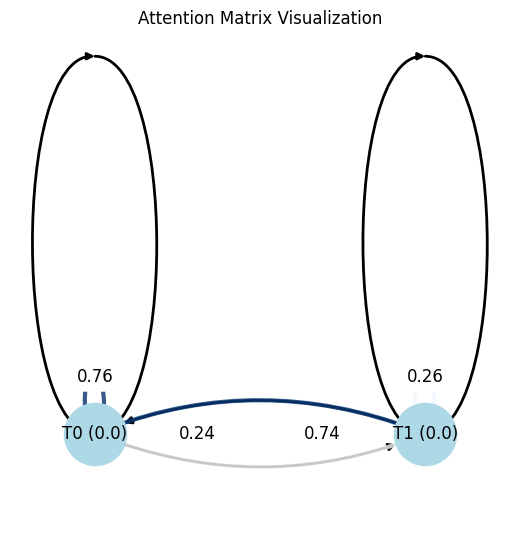

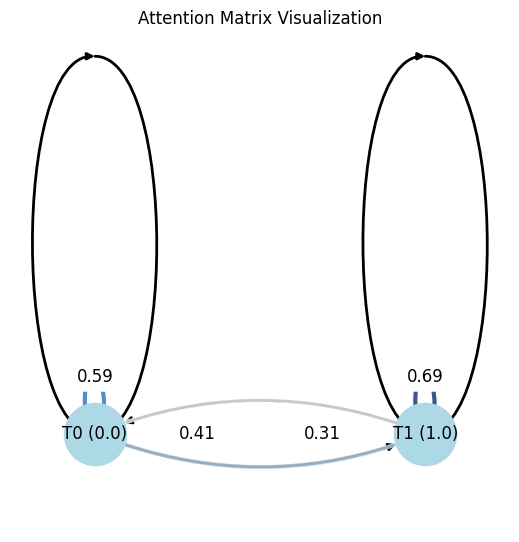

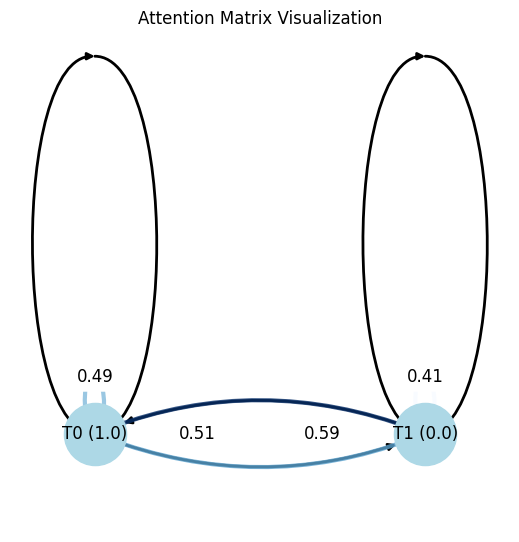

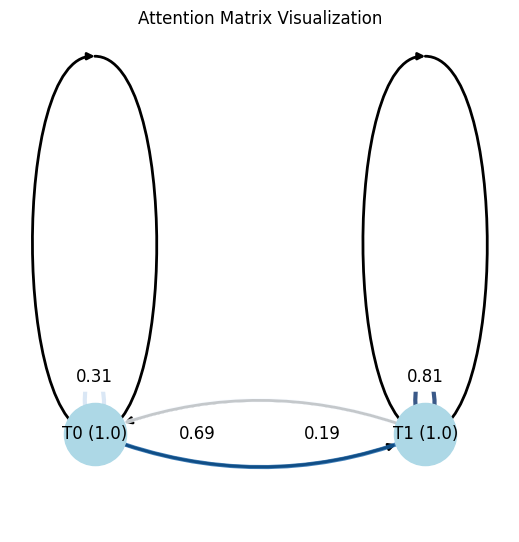

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_attention(A, input_tokens):
    """ Visualizes the attention matrix A using NetworkX with correctly labeled edges. """
    G = nx.DiGraph()

    # Define node labels based on input tokens
    node_labels = {0: f"T0 ({input_tokens[0]})", 1: f"T1 ({input_tokens[1]})"}

    # Add nodes (tokens)
    G.add_nodes_from([0, 1])

    # Extract attention weights and store edges
    edge_labels = {}
    edge_weights = []
    edges = []  # Store edges for correct order

    for i in range(2):
        for j in range(2):
            weight = A[i, j].item()
            edges.append((i, j))
            G.add_edge(i, j, weight=weight)
            edge_labels[(i, j)] = f"{weight:.2f}"
            edge_weights.append(weight)

    # Define positions for better layout
    pos = {0: (-1, 0), 1: (1, 0)}

    # Normalize weights for edge color intensity
    weights = np.array(edge_weights)
    min_w, max_w = weights.min(), weights.max()
    norm_weights = (weights - min_w) / (max_w - min_w + 1e-6)  # Avoid division by zero

    # Define edge colors using a colormap (darker = higher weight)
    edge_colors = [plt.cm.Blues(w) for w in norm_weights]

    plt.figure(figsize=(5, 5))

    # Draw nodes
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, font_size=12,
            node_color='lightblue', edge_color='black', width=2, connectionstyle="arc3,rad=0.2")

    # Draw edges with correct coloring and curvature
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=3, alpha=0.8,
                           connectionstyle="arc3,rad=0.2")

    # Draw edge labels (correctly assigned)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, label_pos=0.3)

    plt.title("Attention Matrix Visualization")
    plt.show()

# Test input to visualize attention
test_input = torch.tensor([[0,0]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)

# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())


# Test input to visualize attention
test_input = torch.tensor([[0,1]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)
# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())

# Test input to visualize attention
test_input = torch.tensor([[1,0]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)
# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())

# Test input to visualize attention
test_input = torch.tensor([[1,1]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)
# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())